In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy import sparse
import skbio as sb
import subprocess as sp
import xml.parsers.expat as expat

import sys

%matplotlib inline
pd.set_option('display.max_rows', None)  # or 1000
display(HTML("<style>.container { width:90% !important; }</style>"))

def extract_ids(path: str, title: str):
    files = glob.glob(f"{path}/{title}_*_profile.txt")
    ids = [ re.search(r".+_(.+)_profile\.txt", file).group(1) for file in files]
    ids.sort()
    return ids


def load_shapemapper_profiles(path: str, title: str, seqids: [str]):
    profiles = {}
    for seqid in seqids:
        try:
            profile = pd.read_csv(f"{path}/{title}_{seqid}_profile.txt", sep="\t")
            profiles[seqid] = profile
        except FileNotFoundError:
            pass
    return profiles

def generate_profile_report(seqid, profile):
    median_mod_dpth = profile['Modified_effective_depth'].median()
    median_untr_dpth = profile['Untreated_effective_depth'].median()
    median_denat_dpth = profile['Denatured_effective_depth'].median()

    qtl95_mod_dpth = profile['Modified_effective_depth'].quantile(0.95)
    qtl95_untr_dpth = profile['Untreated_effective_depth'].quantile(0.95)
    qtl95_denat_dpth = profile['Denatured_effective_depth'].quantile(0.95)
    qtl5_mod_dpth = profile['Modified_effective_depth'].quantile(0.95)
    qtl5_untr_dpth = profile['Untreated_effective_depth'].quantile(0.95)
    qtl5_denat_dpth = profile['Denatured_effective_depth'].quantile(0.95)
    median_mutation_ratio = (profile['Modified_rate'] / profile['Untreated_rate']).median()
    
    try:
        median_norm_reactivity = profile['Norm_profile'].median()
    except KeyError:
        median_norm_reactivity = np.NaN
        
        
    sufficent_depth = median_mod_dpth > 5000 and median_untr_dpth > 5000 and median_denat_dpth > 5000
    sufficent_mutations = median_mutation_ratio > 1.2    
    return pd.Series({
              "median_modified_depth": median_mod_dpth, 
              "median_untreated_depth": median_untr_dpth,
              "median_denatured_depth": median_denat_dpth,
              "median_mutation_ratio": median_mutation_ratio,
              "median_norm_reactivity": median_norm_reactivity,
              "qtl95_modified_depth": qtl95_mod_dpth,
              "qtl95_untreated_depth": qtl95_untr_dpth,
              "qtl95_denatured_depth": qtl95_denat_dpth,
              "qtl5_modified_depth": qtl5_mod_dpth,
              "qtl5_untreated_depth": qtl5_untr_dpth,
              "qtl5_denatured_depth": qtl5_denat_dpth,
              "sufficent_depth": sufficent_depth,
              "sufficent_mutations": sufficent_mutations,
              "len": len(profile.index)})
    
    
def generate_profiles_report(profiles):
    
    report = pd.DataFrame(columns=["median_modified_depth","median_untreated_depth",
                          "median_denatured_depth","median_mutation_ratio",
                          "median_norm_reactivity","qtl95_modified_depth",
              "qtl95_untreated_depth",
              "qtl95_denatured_depth",
              "qtl5_modified_depth",
              "qtl5_untreated_depth",
              "qtl5_denatured_depth",
                          "sufficent_depth", "sufficent_mutations", "len"], index=profiles.keys())
    for seqid, profile in profiles.items():
        rep = generate_profile_report(seqid, profile)
        #print(rep)
        report.loc[seqid] = rep
    return report

def show_svg(path):
    display(SVG(path))
    
    

def extract_delta_ids(path: str, dsname1: str, dsname2: str):
    files = glob.glob(f"{path}/{dsname1}_{dsname2}/*.tsv")
    ids = [ re.search(r"deltashape_(.+?)_.+\.tsv", file).group(1) for file in files]
    ids.sort()
    return ids

def plot_box(df, columns="source", values="medians_median_depth", title="Profondeur de séquençage (median) par source", log=True, rot=45, vert=True):
    sdf = df.pivot(columns=columns, values=values)
    #display(sdf)
    ax = sdf.plot(kind="box", rot=rot, title=title, vert=vert)
    if log:
        if vert:
            ax.set_yscale('log')
        else: 
            ax.set_xscale('log')
    plt.hlines(5000, xmin=0, xmax=sdf.shape[1] + 1, colors="red")
    plt.show()



In [47]:
data_path1 = os.environ.get("DATA_PATH1", ".")
data_path2 = os.environ.get("DATA_PATH2", ".")
condition1 = os.path.basename(data_path1)
condition2 = os.path.basename(data_path2)




sequences1 = {os.path.splitext(path)[0][(len(data_path1)+len(condition1)+2):]  for path in glob.glob(f"{data_path1}/*.shape")}
if len(sequences1) == 0:
    print(f"Could not identify any molecule name in {data_path1}")


sequences2 = {os.path.splitext(path)[0][(len(data_path2)+len(condition2)+2):]  for path in glob.glob(f"{data_path2}/*.shape")}
if len(sequences2) == 0:
    print(f"Could not identify any molecule name in {data_path2}")
    
sequences= sequences1.union(sequences2)


cond1_profiles = load_shapemapper_profiles(data_path1, condition1, sequences)
if len(cond1_profiles) == 0:
    print(f"Condition {data_path1} does not contains any profile file")

cond1_report = generate_profiles_report(cond1_profiles)
cond2_profiles = load_shapemapper_profiles(data_path2, condition2, sequences)
if len(cond2_profiles) == 0:
    print(f"Condition {data_path2} does not contains any profile file")

cond2_report = generate_profiles_report(cond2_profiles)

    



def add_stat(df):
    #df["len"] = next(iter(df.items()))[1]["len"]
    median_depth = [col for col in df.columns if 'median_modified_depth' in col]
    all_median_depth = [col for col in df.columns if any(c in col for c in ['median_modified_depth', 'median_untreated_depth', 'median_denatured_depth'])]
    all_qtl5_depth = [col for col in df.columns if any(c in col for c in ['qtl5_modified_depth', 'qtl5_untreated_depth', 'qtl5_denatured_depth'])]
    all_qtl95_depth = [col for col in df.columns if any(c in col for c in ['qtl95_modified_depth', 'qtl95_untreated_depth', 'qtl95_denatured_depth'])]


    df["medians_median_depth"] = df[all_median_depth].median(axis=1)
    df["lowest_median_depth"] = df[all_median_depth].min(axis=1)
    df["qtl5s_median_depth"] = df[all_qtl5_depth].median(axis=1)
    df["qtl95s_median_depth"] = df[all_qtl95_depth].median(axis=1)
    return df
    
cond1_report = add_stat(cond1_report)
cond2_report = add_stat(cond2_report)

/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

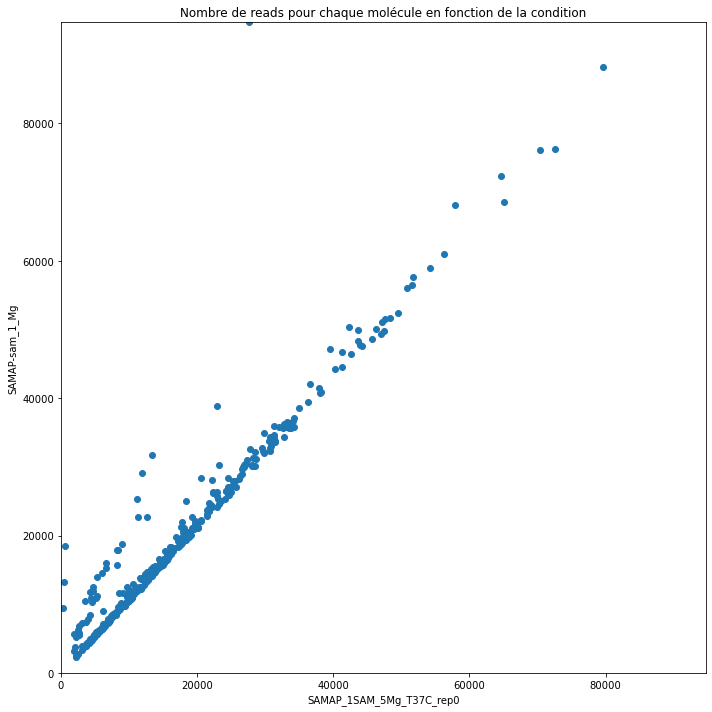

In [46]:
fig, ax = plt.subplots(figsize=(10,10))

union = pd.DataFrame(cond1_report["medians_median_depth"]).join(cond2_report["medians_median_depth"], lsuffix="_cond1", rsuffix="_cond2")

maxlim = max(max(cond1_report["medians_median_depth"]),max(cond2_report["medians_median_depth"]))

plt.xlim(left=0., right=maxlim)
plt.ylim(bottom=0., top=maxlim)
ax.scatter(x=union["medians_median_depth_cond1"],y=union["medians_median_depth_cond2"])

ax.set_xlabel(condition1)
ax.set_ylabel(condition2)
ax.set_title("Nombre de reads pour chaque molécule en fonction de la condition")
plt.tight_layout()
plt.show()


